# Ch5. Statistics

### The Normal Distribution

In [1]:
import math
SQRT_TWO_PI = math.sqrt(2 * math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (SQRT_TWO_PI * sigma))

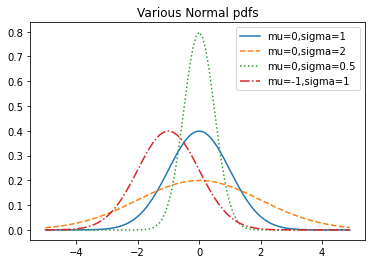

In [2]:
import matplotlib.pyplot as plt
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_pdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_pdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_pdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_pdf(x,mu=-1)   for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend()
plt.title("Various Normal pdfs")
plt.show()

In [3]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

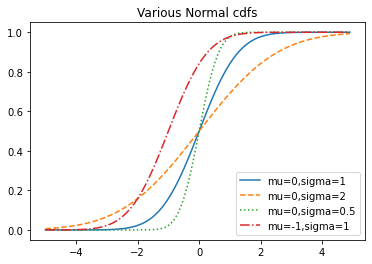

In [4]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")
plt.show()

In [5]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

### The Central Limit Theorem

In [6]:
import random

def bernoulli_trial(p: float) -> int:
    """Returns 1 with probability p and 0 with probability 1-p"""
    return 1 if random.random() < p else 0

def binomial(n: int, p: float) -> int:
    """Returns the sum of n bernoulli(p) trials"""
    return sum(bernoulli_trial(p) for _ in range(n))

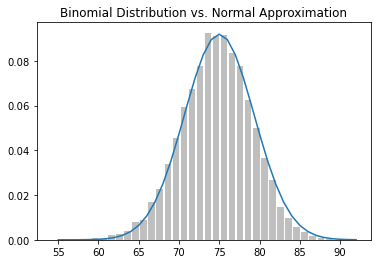

In [7]:
from collections import Counter


def binomial_histogram(p: float, n: int, num_points: int) -> None:
    """Picks points from a Binomial(n, p) and plots their histogram"""
    data = [binomial(n, p) for _ in range(num_points)]

    # use a bar chart to show the actual binomial samples
    histogram = Counter(data)
    plt.bar([x - 0.4 for x in histogram.keys()],
            [v / num_points for v in histogram.values()],
            0.8,
            color='0.75')

    mu = p * n
    sigma = math.sqrt(n * p * (1 - p))

    # use a line chart to show the normal approximation
    xs = range(min(data), max(data) + 1)
    ys = [normal_cdf(i + 0.5, mu, sigma) - normal_cdf(i - 0.5, mu, sigma)
          for i in xs]
    plt.plot(xs,ys)
    plt.title("Binomial Distribution vs. Normal Approximation")
    plt.show()
    
binomial_histogram(0.75, 100, 10000)

# Ch6. Hypothesis and Inference

In [8]:
from typing import Tuple
import math

def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    """Returns mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

In [9]:
from scratch.probability import normal_cdf

# The normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

# It's above the threshold if it's not below the threshold
def normal_probability_above(lo: float,
                             mu: float = 0,
                             sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is greater than lo."""
    return 1 - normal_cdf(lo, mu, sigma)

# It's between if it's less than hi, but not less than lo
def normal_probability_between(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is between lo and hi."""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# It's outside if it's not between
def normal_probability_outside(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is not between lo and hi."""
    return 1 - normal_probability_between(lo, hi, mu, sigma)

<Figure size 432x288 with 0 Axes>

In [10]:
from scratch.probability import inverse_normal_cdf

def normal_upper_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float,
                            mu: float = 0,
                            sigma: float = 1) -> Tuple[float, float]:
    """
    Returns the symmetric (about the mean) bounds
    that contain the specified probability
    """
    tail_probability = (1 - probability) / 2

    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [11]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


In [12]:
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lower_bound, upper_bound)

469.01026640487555 530.9897335951244


In [13]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lo, hi)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print(mu_1, sigma_1)

# a type 2 error means we fail to reject the null hypothesis,
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.887
print(power)

469.01026640487555 530.9897335951244
550.0 15.732132722552274
0.8865480012953671


In [14]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
# is 526 (< 531, since we need more probability in the upper tail)

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.936
print(power)

0.9363794803307173


In [15]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.51)
print(mu_1, sigma_1)

# a type 2 error means we fail to reject the null hypothesis,
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.887
print(power)

510.0 15.8082257068907
0.09688458187649163


### p-value

In [16]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """
    How likely are we to see a value at least as extreme as x (in either
    direction) if our values are from an N(mu, sigma)?
    """
    if x >= mu:
        # x is greater than the mean, so the tail is everything greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # x is less than the mean, so the tail is everything less than x
        return 2 * normal_probability_below(x, mu, sigma)

In [17]:
# 529.5 instead of 530 -> continuity correction
two_sided_p_value(529.5, mu_0, sigma_0)   # 0.062

0.06207721579598835

In [18]:
import random

extreme_value_count = 0
for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0    # Count # of heads
                    for _ in range(1000))                # in 1000 flips,
    if num_heads >= 530 or num_heads <= 470:             # and count how often
        extreme_value_count += 1                         # the # is 'extreme'

# p-value was 0.062 => ~62 extreme values out of 1000
# assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

# what is the use of extreme_value_count? actual test results
# why 59~65? it seems it's just an arbitrary number around 62.
extreme_value_count

54

In [19]:
two_sided_p_value(531.5, mu_0, sigma_0)   # 0.0463

0.046345287837786575

### Confidence Interval

In [20]:
# standard deviation when mean is 525 
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)   # 0.0158

In [21]:
# we can have 95% confidence that 
# the coin is in the range of the pair coin (500)
# since the range is 494~556
normal_two_sided_bounds(0.95, mu, sigma)        # [0.4940, 0.5560]

(0.4940490278129096, 0.5559509721870904)

In [22]:
# In this case we can reject the null hyphothesis 
# since the 95% confidence interval range is outside of 500, 
# the pair coin range.
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) # 0.0158
normal_two_sided_bounds(0.95, mu, sigma) # [0.5091, 0.5709]

(0.5091095927295919, 0.5708904072704082)

### p-Hacking

In [23]:
from typing import List

def run_experiment() -> List[bool]:
    """Flips a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment: List[bool]) -> bool:
    """Using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

num_rejections

46

### Example: Running an A/B Test

In [24]:
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [25]:
# standard normal - what is it?
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [26]:
z = a_b_test_statistic(1000, 200, 1000, 180)    # -1.14

In [27]:
two_sided_p_value(z)                            # 0.254

0.254141976542236

In [28]:
z = a_b_test_statistic(1000, 200, 1000, 150)    # -2.94
two_sided_p_value(z)                            # 0.003

0.003189699706216853

### Bayesian Inference

In [29]:
def B(alpha: float, beta: float) -> float:
    """A normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:          # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

# Ch 10. Working with data

## Exploring Your Data

### Exploring One-Dimensional Data

In [30]:
from typing import List, Dict
from collections import Counter
import math

import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [31]:
import random
from scratch.probability import inverse_normal_cdf

random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
          for _ in range(10000)]

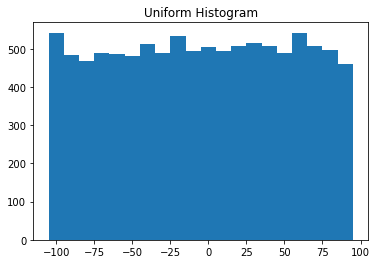

In [32]:
plot_histogram(uniform, 10, "Uniform Histogram")

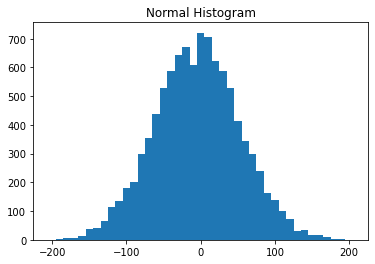

In [33]:
plot_histogram(normal, 10, "Normal Histogram")

### Two Dimensions

In [34]:
def random_normal() -> float:
    """Returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

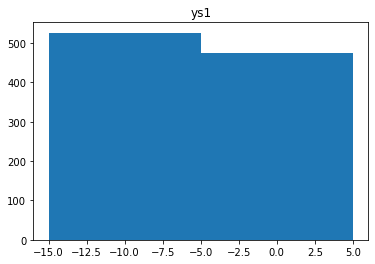

In [35]:
# ??? wrong histogram in the book
plot_histogram(ys1, 10, "ys1")

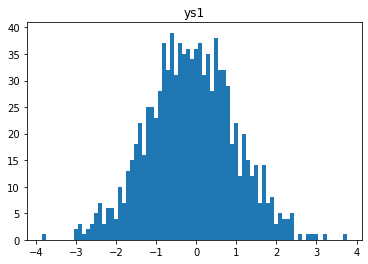

In [36]:
plot_histogram(ys1, 0.1, "ys1")

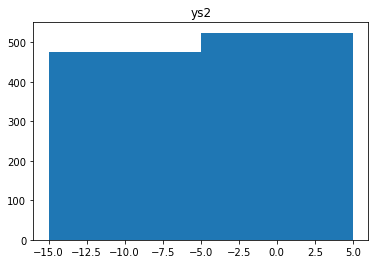

In [37]:
plot_histogram(ys2, 10, "ys2")

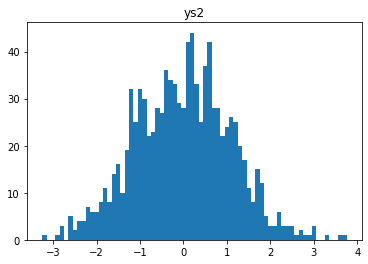

In [38]:
plot_histogram(ys2, 0.1, "ys2")

In [39]:
inverse_normal_cdf(0)

-9.999990463256836

In [40]:
inverse_normal_cdf(0.2)

-0.8416271209716797

In [41]:
inverse_normal_cdf(1)

8.265790939331055

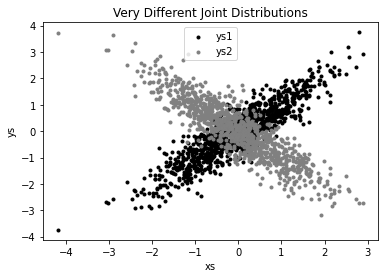

In [42]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

0.9010493686379609
-0.8920981526880033


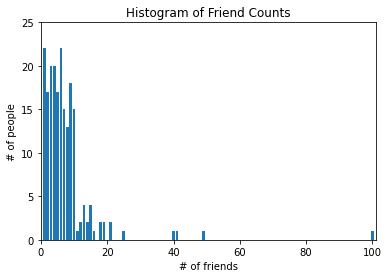

In [43]:
from scratch.statistics import correlation

print(correlation(xs, ys1))      # about 0.9
print(correlation(xs, ys2))      # about -0.9

### Many Dimensions

In [44]:
from scratch.linear_algebra import Matrix, Vector, make_matrix

# TODO: Correlation takes two lists. Are data[i] and data[j] lists?
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Returns the len(data) x len(data) matrix whose (i, j)-th entry
    is the correlation between data[i] and data[j]
    """
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])

    return make_matrix(len(data), len(data), correlation_ij)

## Using NamedTuples

In [45]:
import datetime

# more memory consumption and error-prone key
stock_price = {'closing_price': 102.06,
               'date': datetime.date(2014, 8, 29),
               'symbol': 'AAPL'}

In [46]:
from collections import namedtuple

# no type hints
StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

In [47]:
# typed variant
from typing import NamedTuple

# Very few people use NamedTuple in this way. But they should!
class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

## Dataclasses

In [48]:
# from Python 3.7
# mutable
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == 'MSFT'
assert price2.closing_price == 106.03
assert price2.is_high_tech()

## Cleaning and Munging

In [49]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                      date=parse(date).date(),
                      closing_price=float(closing_price))

# Now test our function
stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

In [50]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

# Should return None for errors
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None

# But should return same as before if data is good
assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

## Manipulating Data

In [51]:
# skip

## Rescaling

In [52]:
# rescale each dimension => mean 0, standard deviation 1

In [53]:
from typing import Tuple

from scratch.linear_algebra import vector_mean
from scratch.statistics import standard_deviation

def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]

    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

In [54]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]

    return rescaled

In [55]:
means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

## An Aside: tqdm

In [56]:
import tqdm

# for i in tqdm.tqdm(range(100)):
#     # do something slow
#     _ = [random.random() for _ in range(1000000)]

100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


In [57]:
# primes info
from typing import List

def primes_up_to(n: int) -> List[int]:
    primes = [2]

    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)

            t.set_description(f"{len(primes)} primes")

    return primes

# my_primes = primes_up_to(100_000)

## Dimensionality Reduction

In [58]:
# skip

# Ch 17. Decision Trees

In [59]:
from typing import List
import math

def entropy(class_probabilities: List[float]) -> float:
    return sum(-p * math.log(p, 2)
              for p in class_probabilities
              if p > 0)

print(entropy([1]))
print(entropy([.5]))
print(entropy([.5, .5]))
print(entropy([.25, .75]))
print(entropy([.5, .5, .5])) # impossible scenario

0.0
0.5
1.0
0.8112781244591328
1.5


In [60]:
from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

print(data_entropy(['a']))
print(data_entropy(['a', 'b', 'a']))
print(data_entropy(['a', 'b']))

0.0
0.9182958340544896
1.0


## The Entropy of Partition

q: proportion,
H: entropy,
S: subset

H=q1H(S1)+...+qmH(Sm)

In [61]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

## Creating a Decision Tree

In [62]:
from typing import NamedTuple, Optional

class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None  # allow unlabeled data

                  #  level     lang     tweets  phd  did_well
inputs = [Candidate('Senior', 'Java',   False, False, False),
          Candidate('Senior', 'Java',   False, True,  False),
          Candidate('Mid',    'Python', False, False, True),
          Candidate('Junior', 'Python', False, False, True),
          Candidate('Junior', 'R',      True,  False, True),
          Candidate('Junior', 'R',      True,  True,  False),
          Candidate('Mid',    'R',      True,  True,  True),
          Candidate('Senior', 'Python', False, False, False),
          Candidate('Senior', 'R',      True,  False, True),
          Candidate('Junior', 'Python', True,  False, True),
          Candidate('Senior', 'Python', True,  True,  True),
          Candidate('Mid',    'Python', False, True,  True),
          Candidate('Mid',    'Java',   True,  False, True),
          Candidate('Junior', 'Python', False, True,  False)
         ]

In [63]:
from typing import List, Any, Dict, TypeVar
from collections import defaultdict

T = TypeVar('T')  # generic type for inputs

# partitions: {'level': [input, ...], 'lang': [input, ...]}
def partition_by(inputs: List[T], attribute: str) -> Dict[Any, List[T]]:
    """Partition the inputs into lists based on the specified attribute."""
    partitions: Dict[Any, List[T]] = defaultdict(list)
    for input in inputs:
        key = getattr(input, attribute)  # value of the specified attribute
        partitions[key].append(input)    # add input to the correct partition
    return partitions

In [64]:
def partition_entropy_by(inputs: List[Any],
                         attribute: str,
                         label_attribute: str) -> float:
    """Compute the entropy corresponding to the given partition"""
    # partitions consist of our inputs
    partitions = partition_by(inputs, attribute)

    # but partition_entropy needs just the class labels
    labels = [[getattr(input, label_attribute) for input in partition]
              for partition in partitions.values()]
    print('labels', labels)

    return partition_entropy(labels)

In [65]:
for key in ['level','lang','tweets','phd']:
    print(key, partition_entropy_by(inputs, key, 'did_well'))
    print()

labels [[False, False, False, True, True], [True, True, True, True], [True, True, False, True, False]]
level 0.6935361388961919

labels [[False, False, True], [True, True, False, True, True, True, False], [True, False, True, True]]
lang 0.8601317128547441

labels [[False, False, True, True, False, True, False], [True, False, True, True, True, True, True]]
tweets 0.7884504573082896

labels [[False, True, True, True, False, True, True, True], [False, False, True, True, True, False]]
phd 0.8921589282623617



In [66]:
senior_inputs = [input for input in inputs if input.level == 'Senior']
senior_inputs

[Candidate(level='Senior', lang='Java', tweets=False, phd=False, did_well=False),
 Candidate(level='Senior', lang='Java', tweets=False, phd=True, did_well=False),
 Candidate(level='Senior', lang='Python', tweets=False, phd=False, did_well=False),
 Candidate(level='Senior', lang='R', tweets=True, phd=False, did_well=True),
 Candidate(level='Senior', lang='Python', tweets=True, phd=True, did_well=True)]

In [67]:
for key in ['lang','tweets','phd']:
    print(key, partition_entropy_by(senior_inputs, key, 'did_well'))
    print()

labels [[False, False], [False, True], [True]]
lang 0.4

labels [[False, False, False], [True, True]]
tweets 0.0

labels [[False, False, True], [False, True]]
phd 0.9509775004326938



## Putting it all together

In [68]:
from typing import NamedTuple, Union, Any

class Leaf(NamedTuple):
    value: Any

class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None

DecisionTree = Union[Leaf, Split]

In [69]:
hiring_tree = Split('level', {   # first, consider "level"
    'Junior': Split('phd', {     # if level is "Junior", next look at "phd"
        False: Leaf(True),       #   if "phd" is False, predict True
        True: Leaf(False)        #   if "phd" is True, predict False
    }),
    'Mid': Leaf(True),           # if level is "Mid", just predict True
    'Senior': Split('tweets', {  # if level is "Senior", look at "tweets"
        False: Leaf(False),      #   if "tweets" is False, predict False
        True: Leaf(True)         #   if "tweets" is True, predict True
    })
})

In [70]:
def classify(tree: DecisionTree, input: Any) -> Any:
    """classify the input using the given decision tree"""

    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value

    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values are subtrees to consider next
    subtree_key = getattr(input, tree.attribute)

    if subtree_key not in tree.subtrees:   # If no subtree for key,
        return tree.default_value          # return the default value.

    subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
    return classify(subtree, input)        # and use it to classify the input.

# Ch 18. Neural Networks

In [72]:
import math

def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))

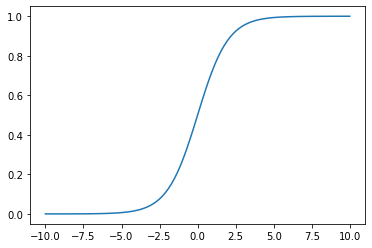

In [73]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, [sigmoid(t) for t in x])
plt.show()

In [74]:
from scratch.linear_algebra import Vector, dot

# dot??

# Ch19. Deep Learning

## The Tensor

In [75]:
from typing import List

Tensor = list

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

In [76]:
def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensional (that is, a vector).
    """
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

In [77]:
def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4]]) == 10

In [78]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

In [79]:
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1, 2, 3]) == [0, 0, 0]
assert zeros_like([[1, 2], [3, 4]]) == [[0, 0], [0, 0]]

In [80]:
def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

import operator
assert tensor_combine(operator.add, [1, 2, 3], [4, 5, 6]) == [5, 7, 9]
assert tensor_combine(operator.mul, [1, 2, 3], [4, 5, 6]) == [4, 10, 18]

## The Layer Abstraction

In [81]:
from typing import Iterable, Tuple

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params().
        """
        return ()

In [82]:
from scratch.neural_networks import sigmoid

class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)

## The Linear Layer

In [83]:
from scratch.probability import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

In [84]:
random_uniform(1)

[0.37459694211488037]

In [85]:
random_uniform(1, 2)

[[0.7970183276730756, 0.9099527274865575]]

In [86]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

In [87]:
from scratch.linear_algebra import dot

class Linear(Layer):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the oth neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the oth neuron
        self.b = random_tensor(output_dim, init=init)
        
    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]
    
    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]
    
    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

## Neural Networks as a Sequence of Layers

In [88]:
from typing import List

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

In [89]:
xor_net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1),
    Sigmoid()
])

## Loss and Optimization

In [90]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

In [91]:
# sum of the squared errors
class SSE(Loss):
    """Loss function that computes the sum of the squared errors."""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # And just add them up
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)

In [92]:
class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

In [93]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

In [94]:
tensor = [[1, 2], [3, 4]]

for row in tensor:
    row = [0, 0]
assert tensor == [[1, 2], [3, 4]], "assignment doesn't update a list"

for row in tensor:
    row[:] = [0, 0]
assert tensor == [[0, 0], [0, 0]], "but slice assignment does"

In [95]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

## Other Activation Functions

In [96]:
import math

def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because, e.g., math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass.
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)

In [97]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

## Softmaxes and Cross-Entropy

In [98]:
def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stability.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight."
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

In [99]:
class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)


In [100]:
from scratch.neural_networks import binary_encode, fizz_buzz_encode, argmax

xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

NUM_HIDDEN = 25

def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
    num_correct = 0
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        if predicted == actual:
            num_correct += 1

    return num_correct / (hi - low)

random.seed(0)

net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
    # No final sigmoid layer now
])

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(100) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)

            optimizer.step(net)

        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")

# Again check results on the test set
# print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 5.288 acc: 1.00: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]  

test results 0.96


## Dropout

In [104]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1.
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")

## Saving and Loading Models

In [102]:
import json

def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)

In [103]:
def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)

    # Check for consistency
    assert all(shape(param) == shape(weight)
               for param, weight in zip(model.params(), weights))

    # Then load using slice assignment
    for param, weight in zip(model.params(), weights):
        param[:] = weight

# Ch 20. Clustering

In [105]:
from scratch.linear_algebra import Vector

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

assert num_differences([1, 2, 3], [2, 1, 3]) == 2
assert num_differences([1, 2], [1, 2]) == 0

In [109]:
from typing import List
from scratch.linear_algebra import vector_mean

def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

In [112]:
import itertools
import random
import tqdm
from scratch.linear_algebra import squared_distance

class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        # itertools.count()
        # https://docs.python.org/3/library/itertools.html#itertools.count
        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

In [119]:
clusterer = KMeans(k=2)

inputs = [[1,1],[1,2],[5,5],[10,9]]

clusterer.train(inputs)
clusterer.means

changed: 2 / 4: : 1it [00:00, 1438.87it/s]


[[7.5, 7.0], [1.0, 1.5]]

## Choosing k

In [120]:
from matplotlib import pyplot as plt

def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

0it [00:00, ?it/s]
changed: 1 / 4: : 1it [00:00, 1088.30it/s]
changed: 1 / 4: : 1it [00:00, 1060.24it/s]
changed: 1 / 4: : 2it [00:00, 1488.13it/s]


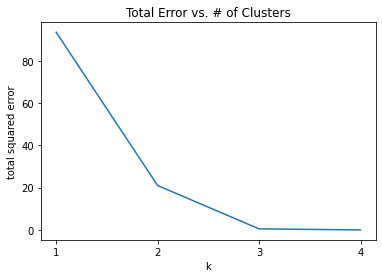

In [121]:
# now plot from 1 up to len(inputs) clusters

ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

## Clustering Colors

In [126]:
image_path = r"stub/cats.jpg"    # wherever your image is
import matplotlib.image as mpimg
img = mpimg.imread(image_path) / 256  # rescale to between 0 and 1
print(len(img), len(img[0]), len(img[0][0]))

1600 1200 3


In [127]:
# .tolist() converts a NumPy array to a Python list
pixels = [pixel.tolist() for row in img for pixel in row]

In [128]:
clusterer = KMeans(5)
clusterer.train(pixels)   # this might take a while

changed: 39 / 1920000: : 16it [06:36, 24.78s/it]    


In [129]:
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

new_img = [[recolor(pixel) for pixel in row]   # recolor this row of pixels
           for row in img]                     # for each row in the image

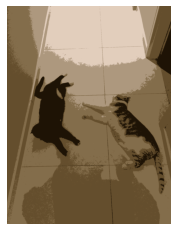

In [130]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

## Bottom-Up Hierarchical Clustering

In [131]:
from typing import NamedTuple, Union

class Leaf(NamedTuple):
    value: Vector

leaf1 = Leaf([10,  20])
leaf2 = Leaf([30, -15])

In [132]:
class Merged(NamedTuple):
    children: tuple
    order: int

merged = Merged((leaf1, leaf2), order=1)

Cluster = Union[Leaf, Merged]

In [133]:
def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]

assert get_values(merged) == [[10, 20], [30, -15]]

In [134]:
from typing import Callable
from scratch.linear_algebra import distance

def cluster_distance(cluster1: Cluster,
                     cluster2: Cluster,
                     distance_agg: Callable = min) -> float:
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting list
    """
    return distance_agg([distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])

In [135]:
def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order

In [136]:
from typing import Tuple

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children

In [137]:
def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

In [138]:
base_cluster = bottom_up_cluster(inputs)

In [139]:
base_cluster

Merged(children=(Merged(children=(Merged(children=(Leaf(value=[1, 2]), Leaf(value=[1, 1])), order=2), Leaf(value=[5, 5])), order=1), Leaf(value=[10, 9])), order=0)

In [140]:
def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [141]:
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]

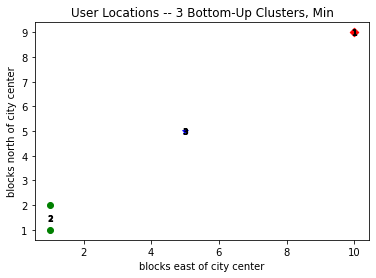

In [142]:
for i, cluster, marker, color in zip([1, 2, 3],
                                     three_clusters,
                                     ['D','o','*'],
                                     ['r','g','b']):
    xs, ys = zip(*cluster)  # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)

    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

# Ch21. Natural Language Processing

### n-Gram Language Models

In [1]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

In [2]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "main-post-radar-content")
regex = r"[\w']+|[\.]"                       # matches a word or a period

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

In [3]:
document[:10]

['Weâ',
 've',
 'all',
 'heard',
 'it',
 'according',
 'to',
 'Hal',
 'Varian',
 'statistics']

In [11]:
len(document)

5225

In [12]:
document[1:5]

['ve', 'all', 'heard', 'it']

In [4]:
from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

In [10]:
import itertools

dict(itertools.islice(transitions.items(), 10))

{'Weâ': ['ve', 're', 've', 're', 've'],
 've': ['all',
  'ever',
  'taken',
  'made',
  'seen',
  'ever',
  'parsed',
  'all',
  'heard',
  'analyzed',
  'seen',
  'collected',
  'all',
  'gotten',
  'just'],
 'all': ['heard',
  'the',
  'of',
  'of',
  'carefully',
  'the',
  'in',
  'equipment',
  'youâ',
  'heard',
  'data',
  'of',
  'heard',
  'locked',
  'at',
  'trying',
  'aspects',
  'tapped',
  'The'],
 'heard': ['it', 'a', 'â', 'the'],
 'it': ['according',
  'to',
  'does',
  'to',
  'to',
  '.',
  'into',
  'tell',
  'comes',
  'and',
  'goes',
  'possible',
  'and',
  '.',
  '.',
  'well',
  'simpler',
  'necessary',
  'and',
  'onto',
  'much',
  '.',
  'might',
  'easy',
  'easier',
  'arrives',
  'takes',
  'complements',
  'comes',
  '.',
  '.',
  'up',
  '.',
  'look',
  'involves',
  'isnâ',
  'tell',
  'started',
  'was',
  '.',
  'â',
  'all',
  'to',
  'to',
  'to',
  'to',
  'â',
  'appears'],
 'according': ['to'],
 'to': ['Hal',
  'a',
  'a',
  'rip',
  'CDDB',


In [15]:
import random

def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

In [16]:
generate_using_bigrams()

'Asking things like to parse plain text for and the data itâ s a thousand words but it .'

In [17]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

In [18]:
def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

In [19]:
generate_using_trigrams()

'Do you really care if you have already reduced the set to 10 000 cores running Linux brought it onto center stage .'

### Grammars

In [21]:
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"], # NP: noun phrase, VP: verb phrase
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

In [22]:
def is_terminal(token: str) -> bool:
    return token[0] != "_"

In [23]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a nonterminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be, e.g., "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here, we had all terminals and are done.
    return tokens

In [24]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

In [28]:
generate_sentence(grammar)

['big', 'Python', 'about', 'logistic', 'Python', 'trains']

### An Aside: Gibbs Sampling

In [30]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

In [31]:
def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

In [32]:
def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [33]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [34]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

### Topic Modeling

In [70]:
# if you give it weights [1, 1, 3], then one-fifth of the time it will return 0, 
# one-fifth of the time it will return 1, 
# and three-fifths of the time it will return 2.
def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

In [71]:
from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190   # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950  # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [72]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [73]:
K = 4

In [74]:
# How many times each topic is assigned to each document:
# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

In [75]:
document_topic_counts

[Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter(),
 Counter()]

In [76]:
# How many times each word is assigned to each topic:
# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

In [77]:
# The total number of words assigned to each topic:
# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

In [78]:
# The total number of words contained in each document:
# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

In [79]:
# The number of distinct words:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

In [80]:
# And the number of documents:
D = len(documents)

In [81]:
#  the number of words in documents[3] associated with topic 1 as follows:
document_topic_counts[3][1]

0

In [82]:
# And we can find the number of times nlp is associated with topic 2 as follows:
topic_word_counts[2]["nlp"]

0

In [83]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document 'd'
    that are assigned to 'topic' (plus some smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to 'topic'
    that equal 'word' (plus some smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

In [84]:
def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

In [85]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [86]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

100%|██████████| 1000/1000 [00:00<00:00, 2227.80it/s]


In [53]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


In [54]:
topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

In [55]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statistics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statistics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big D

### Word vectors